# Recherche de corrélations entre le prix du loyer et la répartition des associations dans Paris Intramuros

## 1. Installations des librairies

In [2]:
!pip install pyspark
!pip install geopandas

## 2. Import des librairies

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType
import seaborn as sns
import geopandas
import numpy as np

## 3. Import des données

In [4]:
# Ajout des schémas pour pouvoir importer nos datasets avec des noms de colonnes propres.

schema_asso = StructType() \
     .add("nom_asso",StringType(),True) \
     .add("code_postal",StringType(),True) \
     .add("ville",StringType(),True) \
     .add("secteur_acti_1",StringType(),True) \
     .add("secteur_acti_2",StringType(),True) \
     .add("secteur_acti_3",StringType(),True) \
     .add("libelle_secteur",StringType(),True) \
     .add("domaine_secteur",StringType(),True) \
     .add("public_vise",StringType(),True) \
     .add("secteur_geo",StringType(),True) \
     .add("id_partenaire",StringType(),True) 

In [5]:
schema_loyer = StructType() \
     .add("secteur_geographique",StringType(),True) \
     .add("numero_quartier",StringType(),True) \
     .add("nom_quartier",StringType(),True) \
     .add("nbre_pieces",IntegerType(),True) \
     .add("epoque_construction",StringType(),True) \
     .add("type_location",StringType(),True) \
     .add("loyer_reference",DoubleType(),True) \
     .add("loyer_reference_majore",DoubleType(),True) \
     .add("loyer_reference_minore",DoubleType(),True) \
     .add("annee",StringType(),True) \
     .add("ville",StringType(),True) \
     .add("code_postal",StringType(),True) 

In [6]:
# Création de la session Spark
spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkParis') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark is ready with CPU usage :', sc.defaultParallelism)

Spark is ready with CPU usage : 12


In [8]:
# Création de nos deux DataFrame Spark
df_assoc_spark = spark.read.option("delimiter", ";").schema(schema_asso).csv("./data/liste_des_associations_parisiennes.csv")
df_loyers_spark = spark.read.option("delimiter", ";").schema(schema_loyer).csv("./data/logement-encadrement-des-loyers.csv")

## 4. Analyse des données

In [9]:
df_assoc_spark.createOrReplaceTempView("assoc_paris")
df_loyers_spark.createOrReplaceTempView("loyers_paris")

In [10]:
df_assoc_spark.show(5)

+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-----------------+
|            nom_asso|         code_postal|           ville|      secteur_acti_1|      secteur_acti_2|      secteur_acti_3|     libelle_secteur|     domaine_secteur|   public_vise|         secteur_geo|    id_partenaire|
+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-----------------+
|   PR-Nom Statutaire|CP-Adresse-Code p...|CP-Adresse-Ville|SA-Secteur d'acti...|SA-Secteur d'acti...|SA-Secteur d'acti...|SA-Libell domain...|SA-Libell secteu...|PV-Public vis|SG-Secteur gogra...|cl id-Partenaire|
|WORLD MUSIC PRODU...|               75020|           PARIS|               Sport|      Culture & Arts|Vie et animation .

In [11]:
df_loyers_spark.show(5)

+--------------------+------------------+---------------+-----------+--------------------+----------------+---------------+----------------------+----------------------+-----+-----+--------------------+
|secteur_geographique|   numero_quartier|   nom_quartier|nbre_pieces| epoque_construction|   type_location|loyer_reference|loyer_reference_majore|loyer_reference_minore|annee|ville|         code_postal|
+--------------------+------------------+---------------+-----------+--------------------+----------------+---------------+----------------------+----------------------+-----+-----+--------------------+
|Secteurs géograph...|Numéro du quartier|Nom du quartier|       null|Epoque de constru...|Type de location|           null|                  null|                  null|Année|Ville|Numéro INSEE du q...|
|                  13|                75|       Amérique|          4|           1946-1970|      non meublé|           14.6|                 17.52|                 10.22| 2020|PARIS|       

In [12]:
# On verifie si il existe des doublons
df_assoc_spark.exceptAll(df_assoc_spark.dropDuplicates()).collect()
df_loyers_spark.exceptAll(df_loyers_spark.dropDuplicates()).collect()

[]

## 5. Recherche de corrélations

In [13]:
# Transformation des associations en tableau SQL
df_assoc_spark.createOrReplaceTempView("asso_spark")

# On sélectionne les 20 arrondissements parisiens et le nombre d'associations dans chacun
asso_par_cp = spark.sql("SELECT code_postal, COUNT(id_partenaire) AS nombre_asso FROM asso_spark WHERE code_postal != '75000' and code_postal LIKE '750%' GROUP BY code_postal ORDER BY code_postal ASC")
asso_par_cp.show(23)

+-----------+-----------+
|code_postal|nombre_asso|
+-----------+-----------+
|      75001|       1004|
|      75002|       1623|
|      75003|       1921|
|      75004|       1286|
|      75005|       3022|
|      75006|        639|
|      75007|       1900|
|      75008|        847|
|      75009|       1061|
|      75010|       4687|
|      75011|       4779|
|      75012|       2890|
|      75013|       9592|
|      75014|       4042|
|      75015|       4344|
|      75016|       2488|
|      75017|       1918|
|      75018|       6461|
|      75019|       6935|
|      75020|       4080|
+-----------+-----------+



In [14]:
# Transformation de la colonne "code_postal", sélection des arrondissements parisiens
df_loyers_spark = df_loyers_spark.rdd.filter(lambda x: x[-1][0:2] != '751') \
                                            .map(lambda x: ('750' + x[-1][3:5], x[6]))

### 5.1 Corrélation 1 
Nombre d'associations et loyer moyen par arrondissement

In [15]:
# Création d'un tableau SQL à partir de notre df_loyers_spark
loyers_par_cp = df_loyers_spark.collect()
loyers_par_cp = spark.createDataFrame(loyers_par_cp, ['code_postal', 'loyer'])
loyers_par_cp.createOrReplaceTempView("loyers_par_cp")

loyers_par_cp_sql = spark.sql("SELECT code_postal, ROUND(AVG(loyer), 2) AS loyer_moyen FROM loyers_par_cp GROUP BY code_postal ORDER BY code_postal ASC")
loyers_par_cp_sql.show(5)

+-----------+-----------+
|code_postal|loyer_moyen|
+-----------+-----------+
|      75001|      27.48|
|      75002|      27.41|
|      75003|      27.14|
|      75004|      27.96|
|      75005|      26.65|
+-----------+-----------+
only showing top 5 rows



#### 5.1.1 Définition de l'histogramme

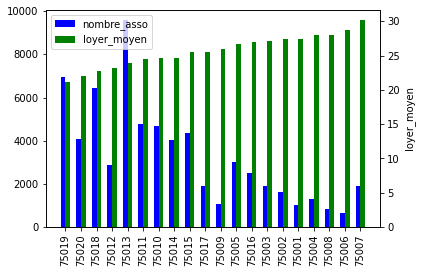

In [16]:
#Pour afficher le nombre d'associations parisiennes par loyer moyen (le tout par arrondissement)
#nous créons un df pandas
asso_par_cp = asso_par_cp.toPandas()
loyers_par_cp_sql = loyers_par_cp_sql.toPandas()

data_cp = pd.DataFrame()
data_cp["code_postal"] = asso_par_cp['code_postal']
data_cp["nombre_asso"] = asso_par_cp['nombre_asso']
data_cp["loyer_moyen"] = loyers_par_cp_sql['loyer_moyen']

data_cp = data_cp.sort_values(by="loyer_moyen")

# Initialiser les valeurs d'entrée
x = data_cp["code_postal"]
y1 = data_cp["nombre_asso"]
y2 = data_cp["loyer_moyen"]

x = np.arange(20)
ax1 = plt.subplot(1,1,1)
w = 0.3 #largeur 

#plt.xticks() : definition du label de x avec les code postaux
plt.xticks(x + w /2, data_cp['code_postal'], rotation='vertical')
#creation du 1er axe y
nombre_asso =ax1.bar(x, data_cp['nombre_asso'], width=w, color='b', align='center')

#On définie 2 axes y aillant la même echelle pour x (twinx)
ax2 = ax1.twinx()
# création du 2eme axe y
loyer_moyen = ax2.bar(x + w, data_cp['loyer_moyen'], width=w,color='g',align='center')

plt.ylabel('loyer_moyen')
plt.legend([nombre_asso, loyer_moyen],['nombre_asso', 'loyer_moyen'])
plt.show()

#### 5.1.2 Observations

In [17]:
# Calcul du coefficient de corrélation et de la matice de covariances 
cd_loyer_nbr_assoc = data_cp["nombre_asso"].corr(data_cp["loyer_moyen"])
cov_loyer_nbr_assoc = data_cp[["nombre_asso","loyer_moyen"]].cov()
print(f"Le nombre d'associations est en correlation inverse\npar rapport à la moyenne des loyers par arrondissement: \nplus le loyer est cher, moins il y a d'associations dans cet arrondissement.\n\nCoef. directeur :  {cd_loyer_nbr_assoc},\nCovariance :\n{cov_loyer_nbr_assoc}")

Le nombre d'associations est en correlation inverse
par rapport à la moyenne des loyers par arrondissement: 
plus le loyer est cher, moins il y a d'associations dans cet arrondissement.

Coef. directeur :  -0.736580405366216,
Covariance :
              nombre_asso  loyer_moyen
nombre_asso  5.582665e+06 -4132.199658
loyer_moyen -4.132200e+03     5.637424


### 5.2 Corrélation 2
Domaine d'activité des associations en fonction de leur arrondissement (et du loyer de celui-ci)

In [18]:
# selection des colonnes "code_postal" et "libelle_secteur"
df_assoc_spark2 = df_assoc_spark.rdd.map(lambda x: (x[1],x[6]))
df_assoc_spark2.take(2)

[('CP-Adresse-Code postal', "SA-Libell\x82 domaine d'activit\x82"),
 ('75020', 'Vie Locale et Citoyenne')]

In [19]:
# Créations d'un tableau SQL avec activite et code_postal
activite_par_cp = spark.createDataFrame(df_assoc_spark2, ['code_postal', 'activite'])
activite_par_cp.createOrReplaceTempView("activite_par_cp")
activite_par_cp = spark.sql("SELECT code_postal, activite FROM activite_par_cp WHERE code_postal LIKE '750%' AND code_postal != '75000' ORDER BY code_postal")
activite_par_cp.show(10)

+-----------+--------------------+
|code_postal|            activite|
+-----------+--------------------+
|      75001| Culture & Education|
|      75001| Culture & Education|
|      75001|Vie Locale et Cit...|
|      75001| Culture & Education|
|      75001| Culture & Education|
|      75001| Culture & Education|
|      75001|Vie Locale et Cit...|
|      75001| Solidarit et Sant|
|      75001|Vie Locale et Cit...|
|      75001| Culture & Education|
+-----------+--------------------+
only showing top 10 rows



In [20]:
#comparer les loyers avec les activités des associations en mergeant les code postaux
#dans un nouveau df : df_activité_loyer
activite_par_cp = activite_par_cp.toPandas()
df_activité_loyer = pd.merge(activite_par_cp, loyers_par_cp_sql, on='code_postal')
df_activité_loyer.describe()


,loyer_moyen
count,65519.000000
mean,24.528194
std,2.155481
min,21.200000
25%,22.710000
50%,24.570000
75%,25.550000
max,30.190000


In [21]:
df_activité_loyer['activite'].value_counts()

Culture & Education        21754
Sports Loisirs             20053
Solidarit et Sant        11549
Vie Locale et Citoyenne     8938
Environnement Urbanisme     2047
Economie et Emploi          1178
Name: activite, dtype: int64

In [22]:
df_repartition = df_activité_loyer.groupby(['code_postal', 'activite']).size().reset_index(name='counts')
df_repartition = df_repartition.merge(df_activité_loyer[["code_postal","loyer_moyen"]], on="code_postal").sort_values(by='loyer_moyen', ascending=True)
df_repartition = df_repartition.drop_duplicates().reset_index(drop=True)
df_repartition.head()

,code_postal,activite,counts,loyer_moyen
0,75019,Solidarit et Sant,2058,21.2
1,75019,Vie Locale et Citoyenne,842,21.2
2,75019,Environnement Urbanisme,173,21.2
3,75019,Sports Loisirs,1883,21.2
4,75019,Culture & Education,1913,21.2


#### 5.2.1 Définition de la matrice de correlation

<AxesSubplot:xlabel='loyer_moyen', ylabel='activite'>

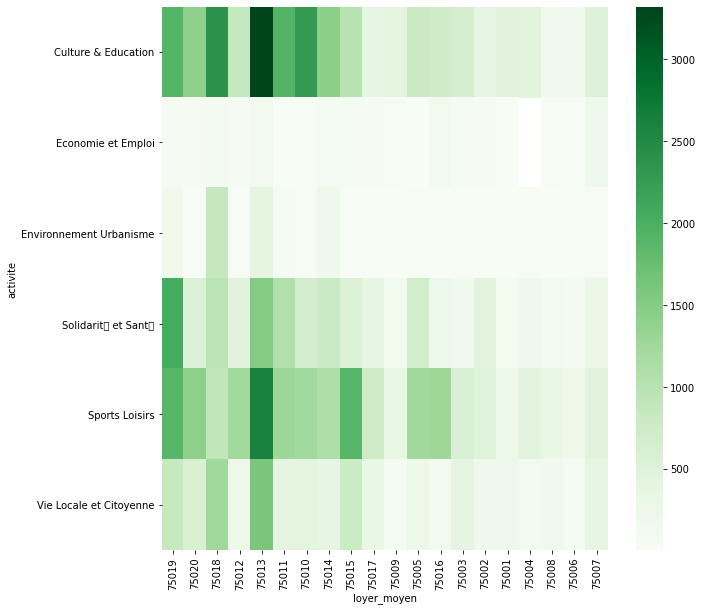

In [24]:
heatmap = df_repartition.pivot(index="activite", columns="loyer_moyen", values="counts")
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(heatmap, cmap="Greens", xticklabels=df_repartition["code_postal"].drop_duplicates())

### 5.3 Corrélation 3
Proportion du nombre d'associations en fonction de leur localisation

#### 5.3.1 Import du 3e dataset "quartier_paris.geojson" et definition de la carte

/Users/raphaelrobert/py_projects/virtual_environment/md4/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


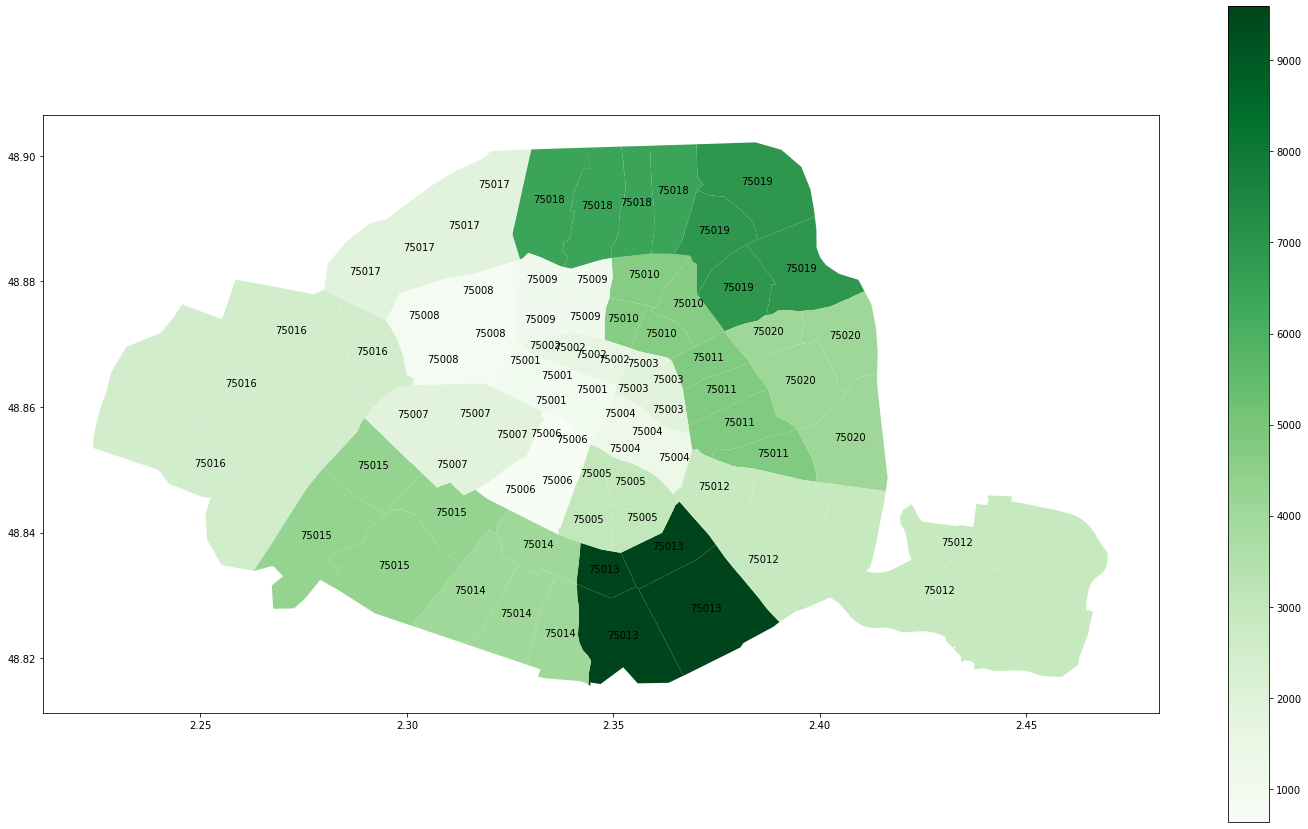

In [27]:
# Utilisation du 3e dataset pour afficher localement le nombre d'associations parisiennes
districts = geopandas.read_file('./data/quartier_paris.geojson')
districts2 = districts.copy()
districts2['c_ar'] = districts['c_ar'].apply(lambda c: int(f"750{c:02d}"))
data_cp.rename({'code_postal': 'c_ar'}, axis=1, inplace=True)
districts2["c_ar"] = districts2["c_ar"].astype(int)
data_cp["c_ar"] = data_cp["c_ar"].astype(int)
merged = pd.merge(districts2, data_cp, on="c_ar")
ax = merged.plot(column='nombre_asso', legend=True, figsize=(25, 15), missing_kwds={'color': 'autumn'}, cmap='Greens')

merged.apply(lambda x: ax.annotate(s=x.c_ar, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
plt.show()